In [1]:
import glob
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.svm import LinearSVC
from skimage.feature import hog
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from sklearn.model_selection import train_test_split

In [2]:
#reading image paths with glob
vehicles = glob.glob('./vehicles/*/*.png')

# read images and append to list
vehicle_images=[]
for imagePath in vehicles:
    readImage=cv2.imread(imagePath)
    rgbImage = cv2.cvtColor(readImage, cv2.COLOR_BGR2RGB)
    vehicle_images.append(rgbImage)

not_vehicles = glob.glob('./non-vehicles/*/*.png')


non_vehicle_images=[]
for imagePath in not_vehicles:
    readImage=cv2.imread(imagePath)
    rgbImage = cv2.cvtColor(readImage, cv2.COLOR_BGR2RGB)
    non_vehicle_images.append(rgbImage)


print("No of Vehicle Images Loaded -"+ str(len(vehicles)))
print("No of Non-Vehicle Images Loaded -"+ str(len(not_vehicles)))

No of Vehicle Images Loaded -8792
No of Non-Vehicle Images Loaded -8968


In [4]:
def ExtractColorHistogram(image, nbins=32, bins_range=(0,255), resize=None):
    if(resize !=None):
        image= cv2.resize(image, resize)
    zero_channel= np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    first_channel= np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    second_channel= np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    return zero_channel,first_channel, second_channel


def FindBinCenter(histogram_channel):
    bin_edges = histogram_channel[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    return bin_centers

def ExtractColorFeatures(zero_channel, first_channel, second_channel):
    return np.concatenate((zero_channel[0], first_channel[0], second_channel[0]))

def SpatialBinningFeatures(image,size):
    image= cv2.resize(image,size)
    return image.ravel()

featureList=SpatialBinningFeatures(vehicle_images[1],(16,16))
print("No of features before spatial binning",len(vehicle_images[1].ravel()))
print("No of features after spatial binning",len(featureList))


No of features before spatial binning 12288
No of features after spatial binning 768


In [5]:
def GetFeaturesFromHog(image,orient,cellsPerBlock,pixelsPerCell, visualise= False, feature_vector_flag=True):
    
    if(visualise==True):
    
        hog_features, hog_image = hog(image, orientations=orient,
                          pixels_per_cell=(pixelsPerCell, pixelsPerCell), 
                          cells_per_block=(cellsPerBlock, cellsPerBlock), 
                          visualise=True, feature_vector=feature_vector_flag)
        return hog_features, hog_image

    else:
        hog_features = hog(image, orientations=orient,
                          pixels_per_cell=(pixelsPerCell, pixelsPerCell), 
                          cells_per_block=(cellsPerBlock, cellsPerBlock), 
                          visualise=False, feature_vector=feature_vector_flag)
        return hog_features

In [6]:

def ConvertImageColorspace(image, colorspace):
    return cv2.cvtColor(image, colorspace)

def ExtractFeatures(images,orientation,cellsPerBlock,pixelsPerCell, convertColorspace=False):
    featureList=[]
    imageList=[]
    for image in images:
        if(convertColorspace==True):
            image= cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        local_features_1=GetFeaturesFromHog(image[:,:,0],orientation,cellsPerBlock,pixelsPerCell, False, True)
        local_features_2=GetFeaturesFromHog(image[:,:,1],orientation,cellsPerBlock,pixelsPerCell, False, True)
        local_features_3=GetFeaturesFromHog(image[:,:,2],orientation,cellsPerBlock,pixelsPerCell, False, True)
        x=np.hstack((local_features_1,local_features_2,local_features_3))
        featureList.append(x)
    return featureList

In [12]:
orientations=9
cellsPerBlock=2
pixelsPerBlock=16
convertColorSpace=True
vehicle_features= ExtractFeatures(vehicle_images,orientations,cellsPerBlock,pixelsPerBlock, convertColorSpace)
nonvehicle_features= ExtractFeatures(non_vehicle_images,orientations,cellsPerBlock,pixelsPerBlock, convertColorSpace)

/home/harpreet/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [15]:
features_list= np.vstack([vehicle_features, nonvehicle_features])
print("Shape of features list is ", features_list.shape)

label_list= np.concatenate([np.ones(len(vehicle_features)), np.zeros(len(nonvehicle_features))])
print("Shape of label list is ", label_list.shape)

Shape of features list is  (17760, 972)
Shape of label list is  (17760,)


In [16]:
X_train,  X_test,Y_train, Y_test = train_test_split(features_list, label_list, test_size=0.2, shuffle=True)

scaler= StandardScaler()

scaler.fit(X_train)

X_train_scaled= scaler.transform(X_train)
X_test_scaled= scaler.transform(X_test)

In [17]:
classifier1= LinearSVC()
classifier1.fit(X_train,Y_train)
print("accuracy of svc is  ", classifier1.score(X_test,Y_test) )

accuracy of svc is   0.987894144144


In [18]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):

    imcopy = np.copy(img)
    
    for bbox in bboxes:
        r=random.randint(0,255)
        
        g=random.randint(0,255)
        
        b=random.randint(0,255)
        
        color=(r, g, b)
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    
    return imcopy

In [19]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.9, 0.9)):
   
    if x_start_stop[0] == None:
        x_start_stop[0]=0
    if x_start_stop[1] == None:
        x_start_stop[1]=img.shape[1]
    if y_start_stop[0] ==  None:
        y_start_stop[0]= 0
    if y_start_stop[1] ==  None:
        y_start_stop[1]=img.shape[0]
    
    
    window_list = []
    
    image_width_x= x_start_stop[1] - x_start_stop[0]
    
    image_width_y= y_start_stop[1] - y_start_stop[0]
     
    
    windows_x = np.int( 1 + (image_width_x - xy_window[0])/(xy_window[0] * xy_overlap[0]))
    
    windows_y = np.int( 1 + (image_width_y - xy_window[1])/(xy_window[1] * xy_overlap[1]))
    
    
    modified_window_size= xy_window
    
    for i in range(0,windows_y):
    
        y_start = y_start_stop[0] + np.int( i * modified_window_size[1] * xy_overlap[1])
        
        for j in range(0,windows_x):
        
            x_start = x_start_stop[0] + np.int( j * modified_window_size[0] * xy_overlap[0])
            
            x1 = np.int( x_start +  modified_window_size[0])
            
            y1= np.int( y_start + modified_window_size[1])
            
            window_list.append(((x_start,y_start),(x1,y1)))
    
    return window_list
    

In [20]:
def DrawCars(image,windows, converColorspace=False):
    refinedWindows=[]
    
    for window in windows:
        
        start= window[0]
        end= window[1]
        
        clippedImage=image[start[1]:end[1], start[0]:end[0]]
        
        if(clippedImage.shape[1] == clippedImage.shape[0] and clippedImage.shape[1]!=0):
            
            clippedImage=cv2.resize(clippedImage, (64,64))
            
            f1=ExtractFeatures([clippedImage], 9 , 2 , 16,converColorspace)
        
            predictedOutput=classifier1.predict([f1[0]])
            
            if(predictedOutput==1):
                refinedWindows.append(window)
        
    return refinedWindows

In [21]:
def DrawCarsOptimised(image, image1, image2,windows, converColorspace=False):
    refinedWindows=[]
    for window in windows:
        
        start= window[0]
        
        end= window[1]
        
        clippedImage=image[start[1]:end[1], start[0]:end[0]]
        
        clippedImage1=image1[start[1]:end[1], start[0]:end[0]]
        
        clippedImage2=image2[start[1]:end[1], start[0]:end[0]]
        
        if(clippedImage.shape[1] == clippedImage.shape[0] and clippedImage.shape[1]!=0):
            
            clippedImage=cv2.resize(clippedImage, (64,64)).ravel()
            
            clippedImage1=cv2.resize(clippedImage1, (64,64)).ravel()
            
            clippedImage2=cv2.resize(clippedImage2, (64,64)).ravel()
            
            #f1=ExtractFeatures([clippedImage], 9 , 2 , 16,converColorspace)
            f1= np.hstack((clippedImage,clippedImage1,clippedImage2))
            
            f1=scaler.transform(f1.reshape(1,-1))   
            
            print(f1.shape)
            
            predictedOutput=classifier1.predict([f1[0]])
            
            if(predictedOutput==1):
        
                refinedWindows.append(window)
        
        
    return refinedWindows

In [22]:
image = mpimg.imread('test_images/test3.jpg')

windows1 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,464], 
                    xy_window=(64,64), xy_overlap=(0.15, 0.15))

windows4 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,480], 
                        
                    xy_window=(80,80), xy_overlap=(0.2, 0.2))

windows2 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,612], 
                    xy_window=(96,96), xy_overlap=(0.3, 0.3))

windows3 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,660], 
                    xy_window=(128,128), xy_overlap=(0.5, 0.5))


windows = windows1 + windows2 +  windows3 + windows4

print("Total No of windows are ",len(windows))

refinedWindows=DrawCars(image,windows, True)



Total No of windows are  470


/home/harpreet/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


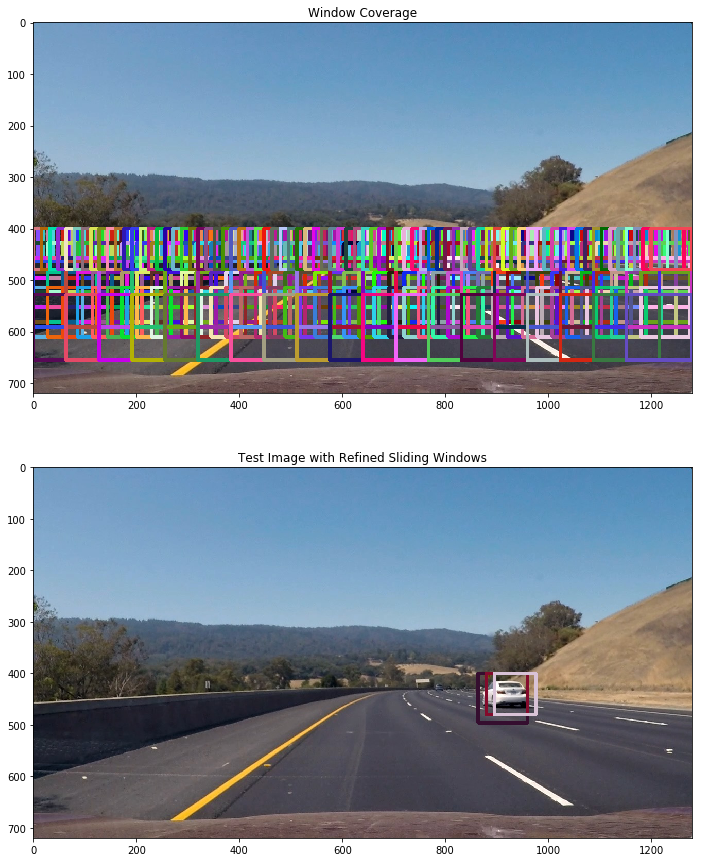

In [23]:
f,axes= plt.subplots(2,1, figsize=(30,15))

window_img = draw_boxes(image, windows) 

axes[0].imshow(window_img)
axes[0].set_title("Window Coverage")

window_img = draw_boxes(image, refinedWindows) 

axes[1].set_title("Test Image with Refined Sliding Windows")
axes[1].imshow(window_img)


In [24]:
def add_heat(heatmap, bbox_list):
    
    for box in bbox_list:

        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    
    return heatmap 

In [25]:
def apply_threshold(heatmap, threshold):
    
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    
    return heatmap

In [26]:
def draw_labeled_bboxes(img, labels):
    
    for car_number in range(1, labels[1]+1):
        
        nonzero = (labels[0] == car_number).nonzero()
        
        
        nonzeroy = np.array(nonzero[0])
        
        nonzerox = np.array(nonzero[1])
        
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))

        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

In [27]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

heat = add_heat(heat,refinedWindows)
    
heat = apply_threshold(heat,3)

heatmap = np.clip(heat, 0, 255)

heat_image=heatmap

labels = label(heatmap)
print(" Number of Cars found - ",labels[1])
draw_img = draw_labeled_bboxes(np.copy(image), labels)



 Number of Cars found -  0


In [28]:
class KeepTrack():
    def __init__(self):
        self.refinedWindows = [] 
        
    def AddWindows(self, refinedWindow):
        self.refinedWindows.append(refinedWindow)
        frameHistory=15
        if len(self.refinedWindows) > frameHistory:
            self.refinedWindows = self.refinedWindows[len(self.refinedWindows)-frameHistory:]


In [29]:
orientation=9 
cellsPerBlock=2 
pixelsPerCell=16 
xy_window=(64, 64) 
xy_overlap=(0.15, 0.15) # Window Overlap. 
x_start_stop=[0, image.shape[1]] 
y_start_stop=[400, 660] 


windows_normal = slide_window(image, x_start_stop, [400,464], 
                    xy_window, xy_overlap)


xy_window_1_25= (80,80)
xy_window_1_25_overlap=(0.2, 0.2)    
windows_1_25 = slide_window(image, x_start_stop, [400,480], 
                    xy_window_1_25, xy_window_1_25_overlap)


xy_window_1_5= (96,96)
xy_window_1_5_overlap=(0.3, 0.3)    
windows_1_5 = slide_window(image, x_start_stop, [400,612], 
                    xy_window_1_5, xy_window_1_5_overlap)

xy_window_twice_overlap=(0.5, 0.5)    
xy_window_twice = (128,128)
windows_twice = slide_window(image, x_start_stop, [400,660], 
                    xy_window_twice, xy_window_twice_overlap)

windows= windows_normal +  windows_1_5  + windows_twice +windows_1_25
print("No of Windows are ",len(windows))

No of Windows are  470


In [30]:
def Pipeline(image):
    rand= random.randint(0,1)
    
    if(rand<0.4):
        refinedWindows=keepTrack.refinedWindows[:-1]
    
    else:
    
        refinedWindows=DrawCars(image,windows, True)
        
        if len(refinedWindows) > 0:
        
            keepTrack.AddWindows(refinedWindows)
        
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    for refinedWindow in keepTrack.refinedWindows:
        
        heat = add_heat(heat, refinedWindow)
    
    
    
    heatmap = apply_threshold(heat, 25 + len(keepTrack.refinedWindows)//2)
    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

In [31]:
# Defining a different pipeline to process the images as we do not want to keep track of previous frames here

def PipelineImage(image):

    refinedWindows=DrawCars(image,windows, True)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,refinedWindows)
   
    heatmap = np.clip(heat, 0, 255)
    heatmap = apply_threshold(heat, 4)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img,heatmap

/home/harpreet/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0


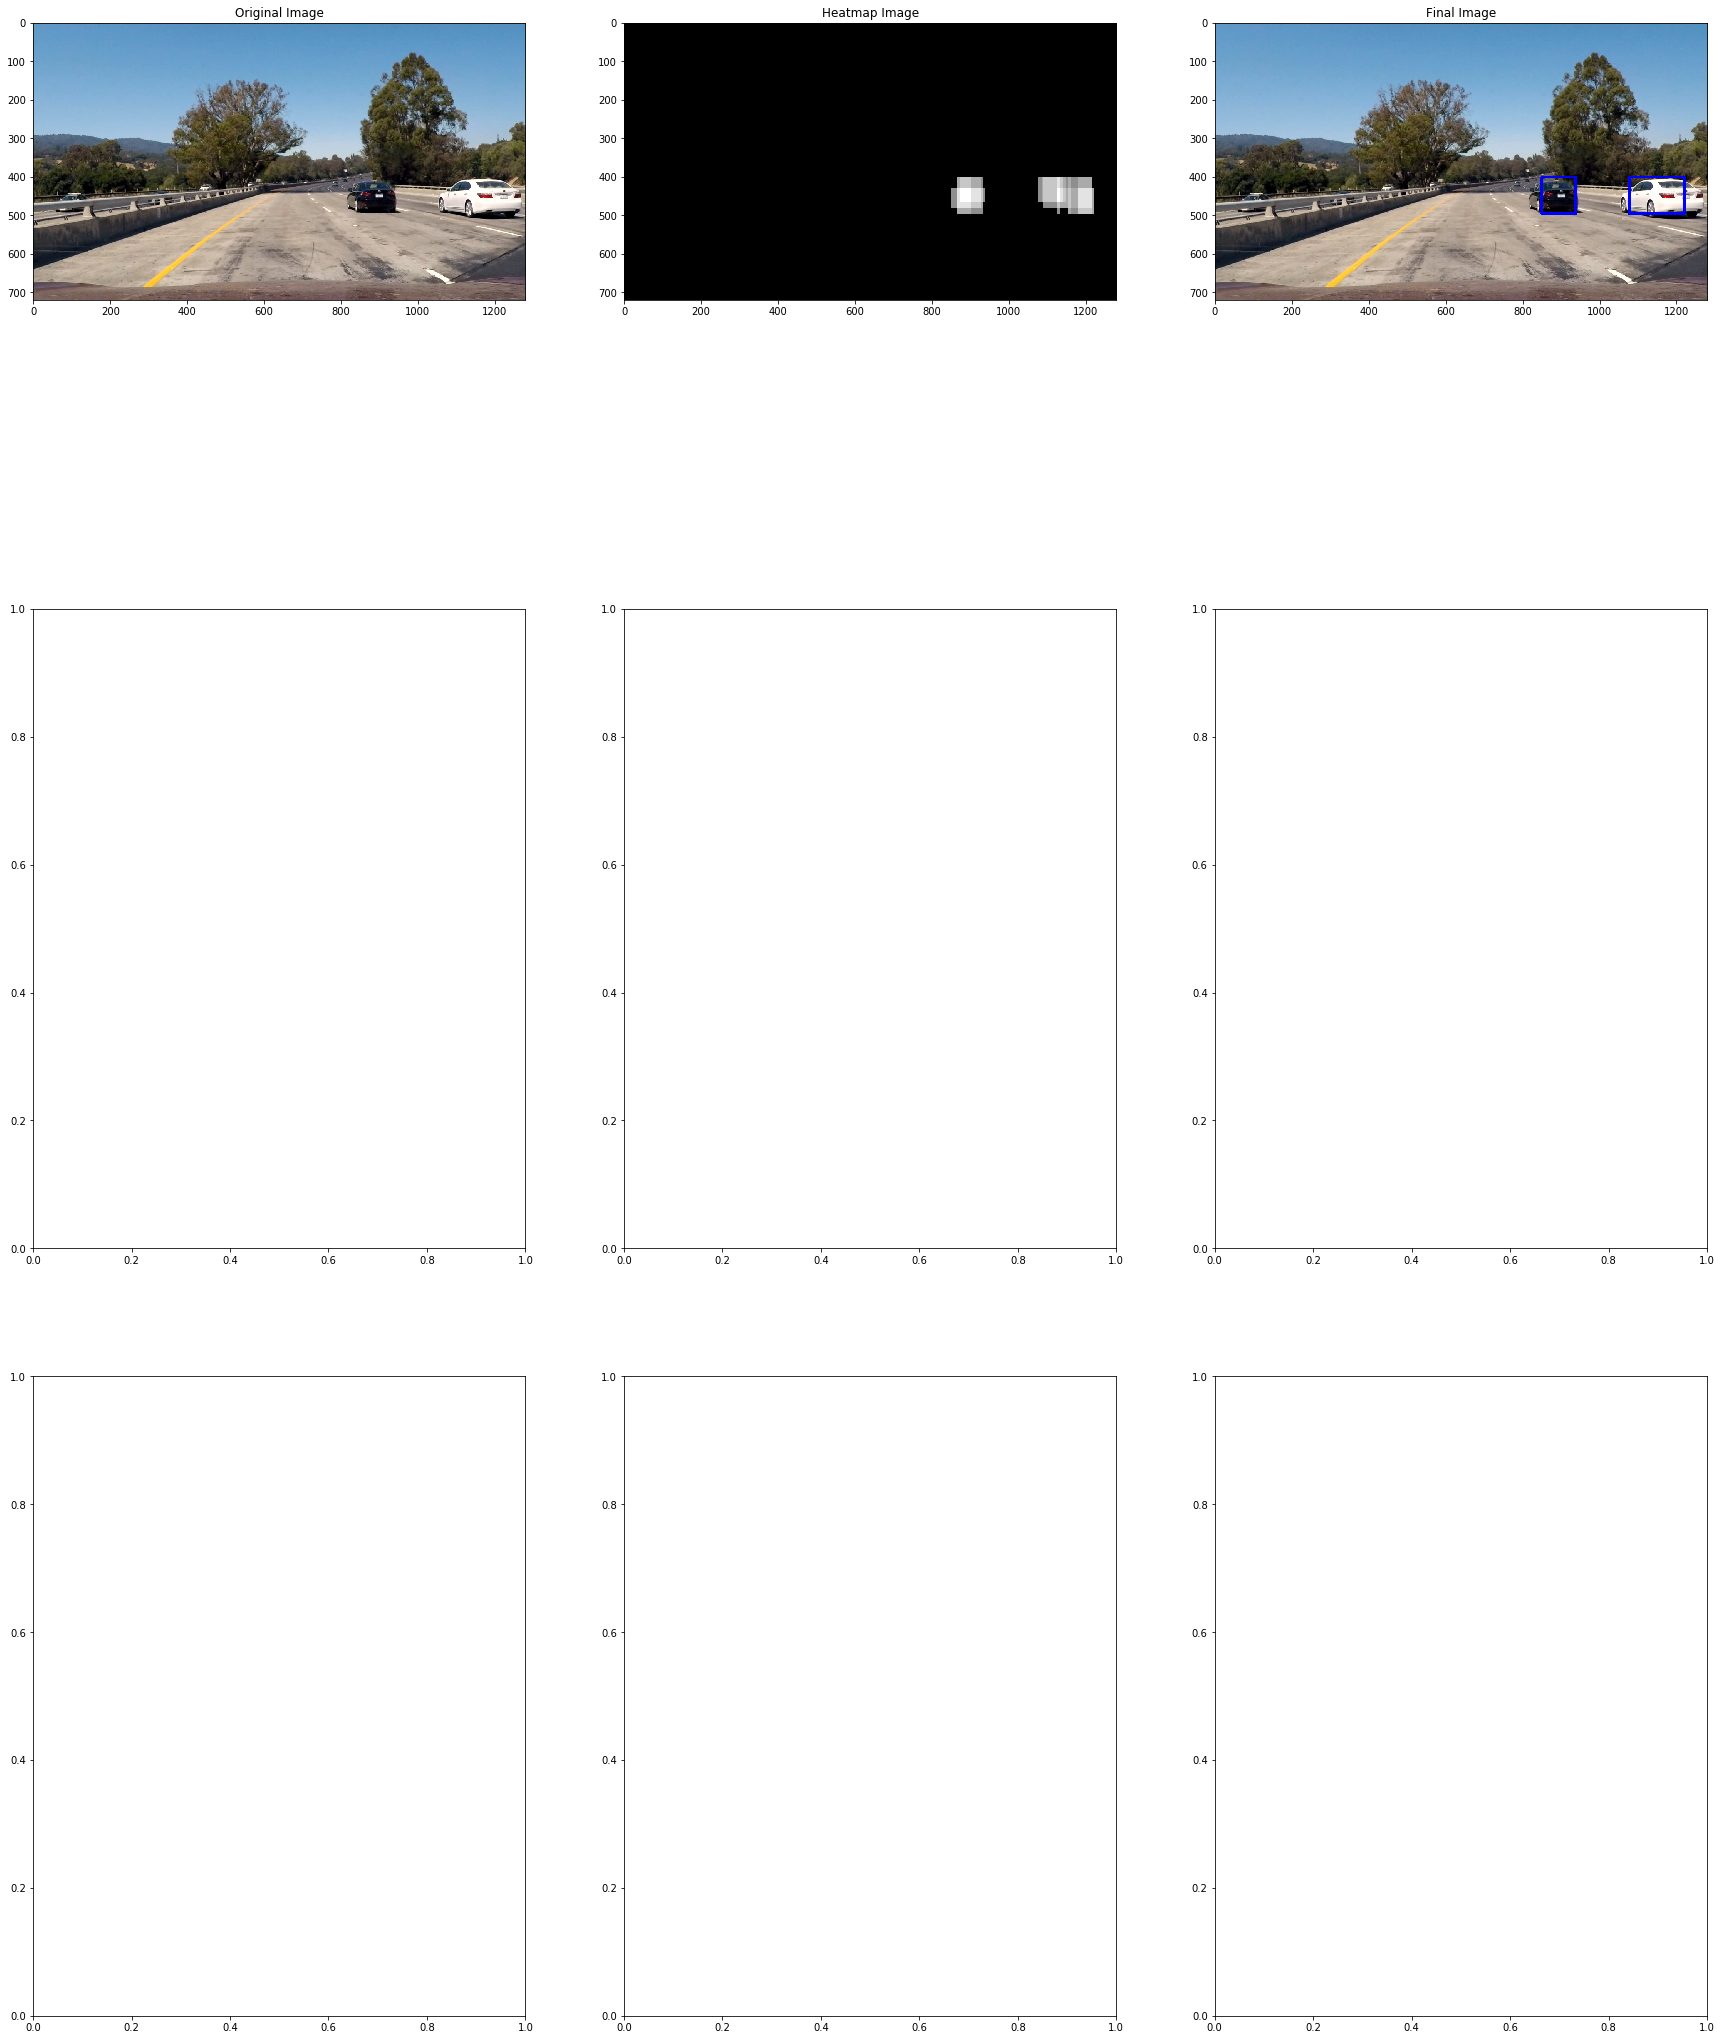

In [36]:
test_images= glob.glob("./test_images/*.jpg")

f, axes= plt.subplots(3,3, figsize=(30,40))

for index,image in enumerate(test_images):

    image = cv2.imread(image)
    
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
    finalPic,heatmap = PipelineImage(image)
    
    axes[index,0].imshow(image)
    axes[index,0].set_title("Original Image")
    axes[index,1].imshow(heatmap,cmap='gray')
    axes[index,1].set_title("Heatmap Image")
    axes[index,2].imshow(finalPic)
    axes[index,2].set_title("Final Image")
    
    break


In [32]:
keepTrack = KeepTrack()
import moviepy
from moviepy.editor import VideoFileClip
video_output1 = 'post_video_processing.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(Pipeline)
%time processed_video.write_videofile(video_output1, audio=False)
video_input1.reader.close()
video_input1.audio.reader.close_proc()

[MoviePy] >>>> Building video full_video_threshold_20_with_frame_skipping_my.mp4
[MoviePy] Writing video full_video_threshold_20_with_frame_skipping_my.mp4


100%|█████████▉| 1260/1261 [14:57<00:00,  1.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: full_video_threshold_20_with_frame_skipping_my.mp4 

CPU times: user 14min 43s, sys: 2.44 s, total: 14min 46s
Wall time: 14min 58s
